# *Project: Predicting the Extent of Forest Fire Damage*


---

###  **Project Goal**
The objective of this project is to develop a machine learning model capable of **estimating the burned area** from forest fires, with a focus on analyzing data from Montesinho park in Portugal.

---

###  **Dataset & Challenges**
* **Source:** We will be using the publicly available **`forestfires.csv`** dataset.
* **Primary Challenge:** The main difficulty lies in the **severe imbalance** of the target variable (`area`), as the majority of recorded fires do not cause significant damage. This requires specialized techniques to ensure the model can effectively predict rare but critical events.

---

###  **Methodology**
1.  **Exploratory Data Analysis (EDA):** Conduct an in-depth analysis to understand the patterns and relationships within the data.
2.  **Model Building:** Develop a predictive model primarily using the **XGBoost Regressor** algorithm.
3.  **Performance Tuning:** Explore and implement various techniques to enhance the model's accuracy and performance.

---

###  **Evaluation Benchmark**
To measure the success of our model, we will use the result from a previous study as a baseline for comparison. The goal is to achieve a better score than the **Root Mean Squared Error (RMSE)** of **63.7** reported in that study.

Data overview


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, plot_importance
import scipy.stats as st

Data structure

In [2]:
df = pd.read_csv('forestfires.csv')
print('The original data has {} entries and {} features.'.format(df.shape[0],df.shape[1]))
print('')
print('First five entries of the dataset:')
df.head()

The original data has 517 entries and 13 features.

First five entries of the dataset:


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


**Data type and missing values**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [4]:
df.isnull().any()

,0
X,False
Y,False
month,False
day,False
FFMC,False
DMC,False
DC,False
ISI,False
temp,False
RH,False


### **Understanding the Dataset Features**

The foundation of this project is the `forestfires.csv` dataset, which was prepared for academic research. This is beneficial as the data is already high-quality and complete, with **no missing values**. The features are primarily numerical, with the exception of the `month` and `day` columns.

Below is a detailed breakdown of each feature available in the dataset:

---

#### **1. Spatiotemporal Features**
* **`X` & `Y`**: The spatial coordinates representing the fire's location on the Montesinho park map. Although these are integers, they should be treated as **categorical** data since they represent distinct locations.
* **`month`**: The month of the year when the fire occurred (e.g., "aug", "sep").
* **`day`**: The day of the week when the fire occurred (e.g., "fri", "sun").

---

#### **2. Fire Weather Index (FWI) System Components**
This is a set of standardized indices used to measure fire danger:
* **`FFMC` (Fine Fuel Moisture Code)**: Reflects the moisture content of surface litter, which is crucial for ignition and initial fire spread.
* **`DMC` (Duff Moisture Code)**: Indicates the moisture of shallow organic layers, influencing the fire's intensity.
* **`DC` (Drought Code)**: Represents the moisture of deep, compact organic layers, also related to fire intensity.
* **`ISI` (Initial Spread Index)**: Measures the potential speed of the fire's spread based on wind.

---

#### **3. Direct Weather Measurements**
* **`temp`**: The temperature in degrees Celsius (°C).
* **`RH`**: The relative humidity in percent (%).
* **`wind`**: The wind speed in kilometers per hour (km/h).
* **`rain`**: The amount of rainfall measured in mm/m².

---

#### **4. Target Variable**
* **`area`**: The total burned area of the forest in hectares (ha). **This is the value our model aims to predict.**

---

### **Strategic Decision: Excluding the 'day' Feature**
A key decision in our data preparation is to **exclude the `day` column** from the analysis. The day of the week, in isolation, lacks meaningful predictive power. Without knowing the "week of the month," a pattern like "more fires on Sundays in August" is not statistically reliable and could introduce noise into our model. Therefore, this feature will be dropped to focus on more impactful variables.

# *EDA*

Since many features, especially those index values, are derived from other low-level features, it is expected that they are highly related. If they are indeed correlated, those features may introduce undersirable redundancies

In [5]:
sns.set_style('white')
%matplotlib inline

Index correlation

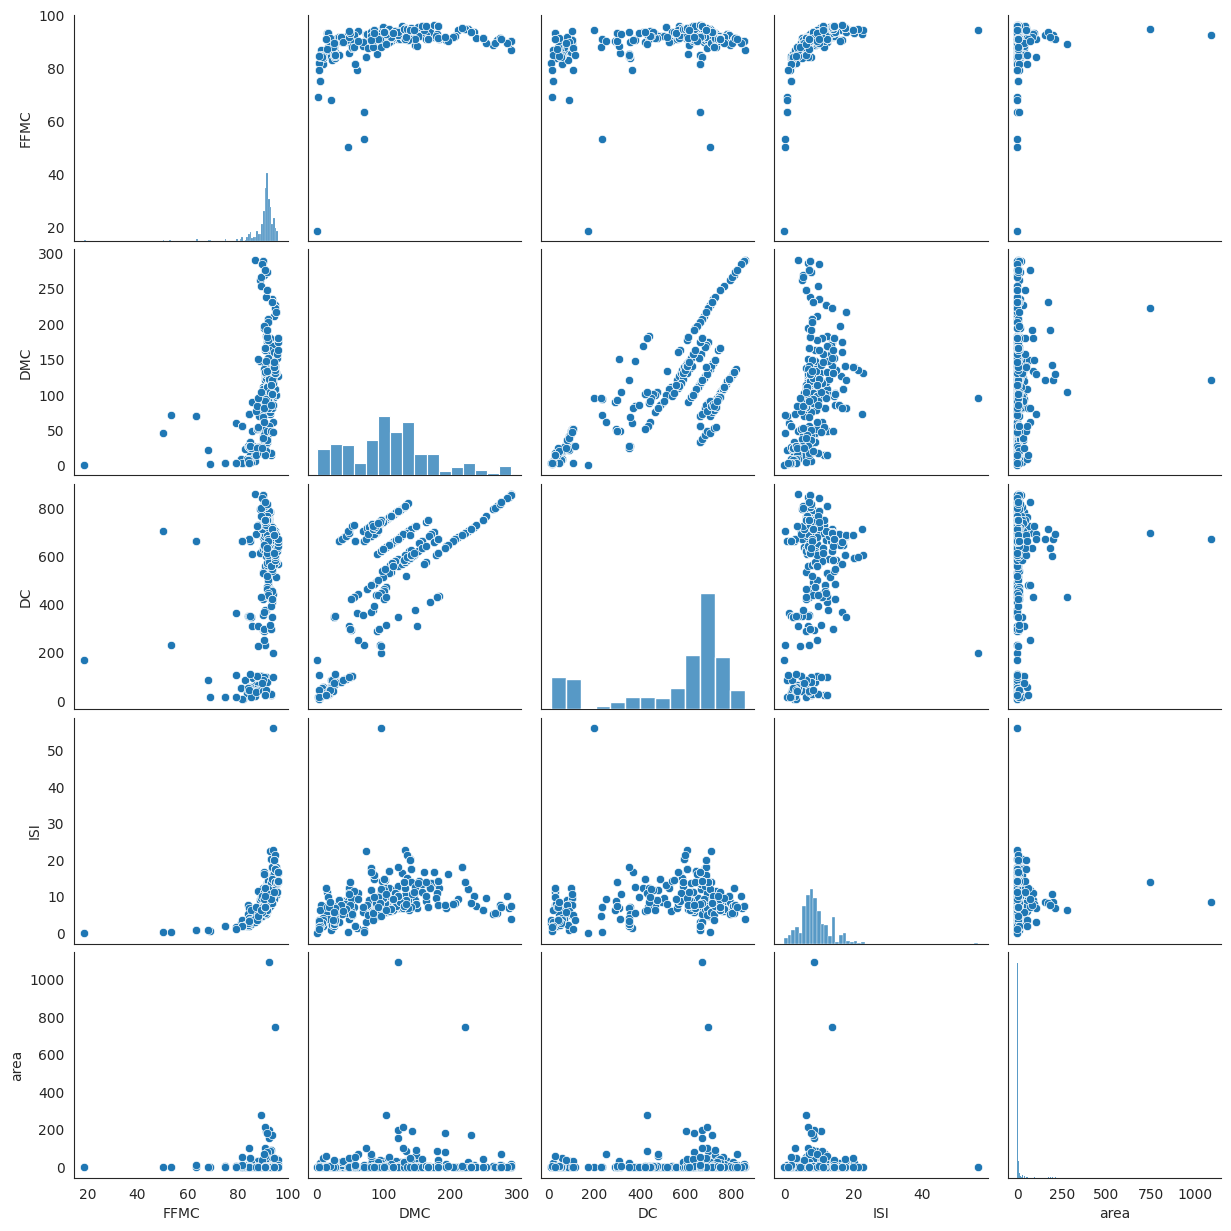

In [6]:
col_pairplot = ['FFMC', 'DMC', 'DC','ISI','area']
df_pairplot = df[col_pairplot]
sns.pairplot(df_pairplot)
plt.show()

 **Analysis of Fire Index Correlations**

This pairplot provides an initial look into the relationships between the key fire indices and the resulting burned `area`. Several important observations can be made:

* **Strong Correlation**: A clear positive correlation exists between **`DC`** and **`DMC`**. This is logical, as both indices are measures of moisture content in different layers of organic fuel on the forest floor.

* **Distribution Skew**: The distributions for **`ISI`** and **`FFMC`** are noticeably **positively skewed** (skewed to the right).

* **Critical Finding**: The most significant observation from this plot is the **severe positive skew** in our target variable, **`area`**. This confirms that the vast majority of fire incidents result in a very small or zero burned area. This data imbalance is a central challenge that must be addressed in our modeling strategy.

**Time series**

month and day features are not ordered in this dataset. In order to have them in order, they first need to be converted to ordinal categorical types

In [7]:
df.month = df.month.astype('category').cat.reorder_categories(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
df.day = df.day.astype('category').cat.reorder_categories(['sun','mon','tue','wed','thu','fri','sat'])

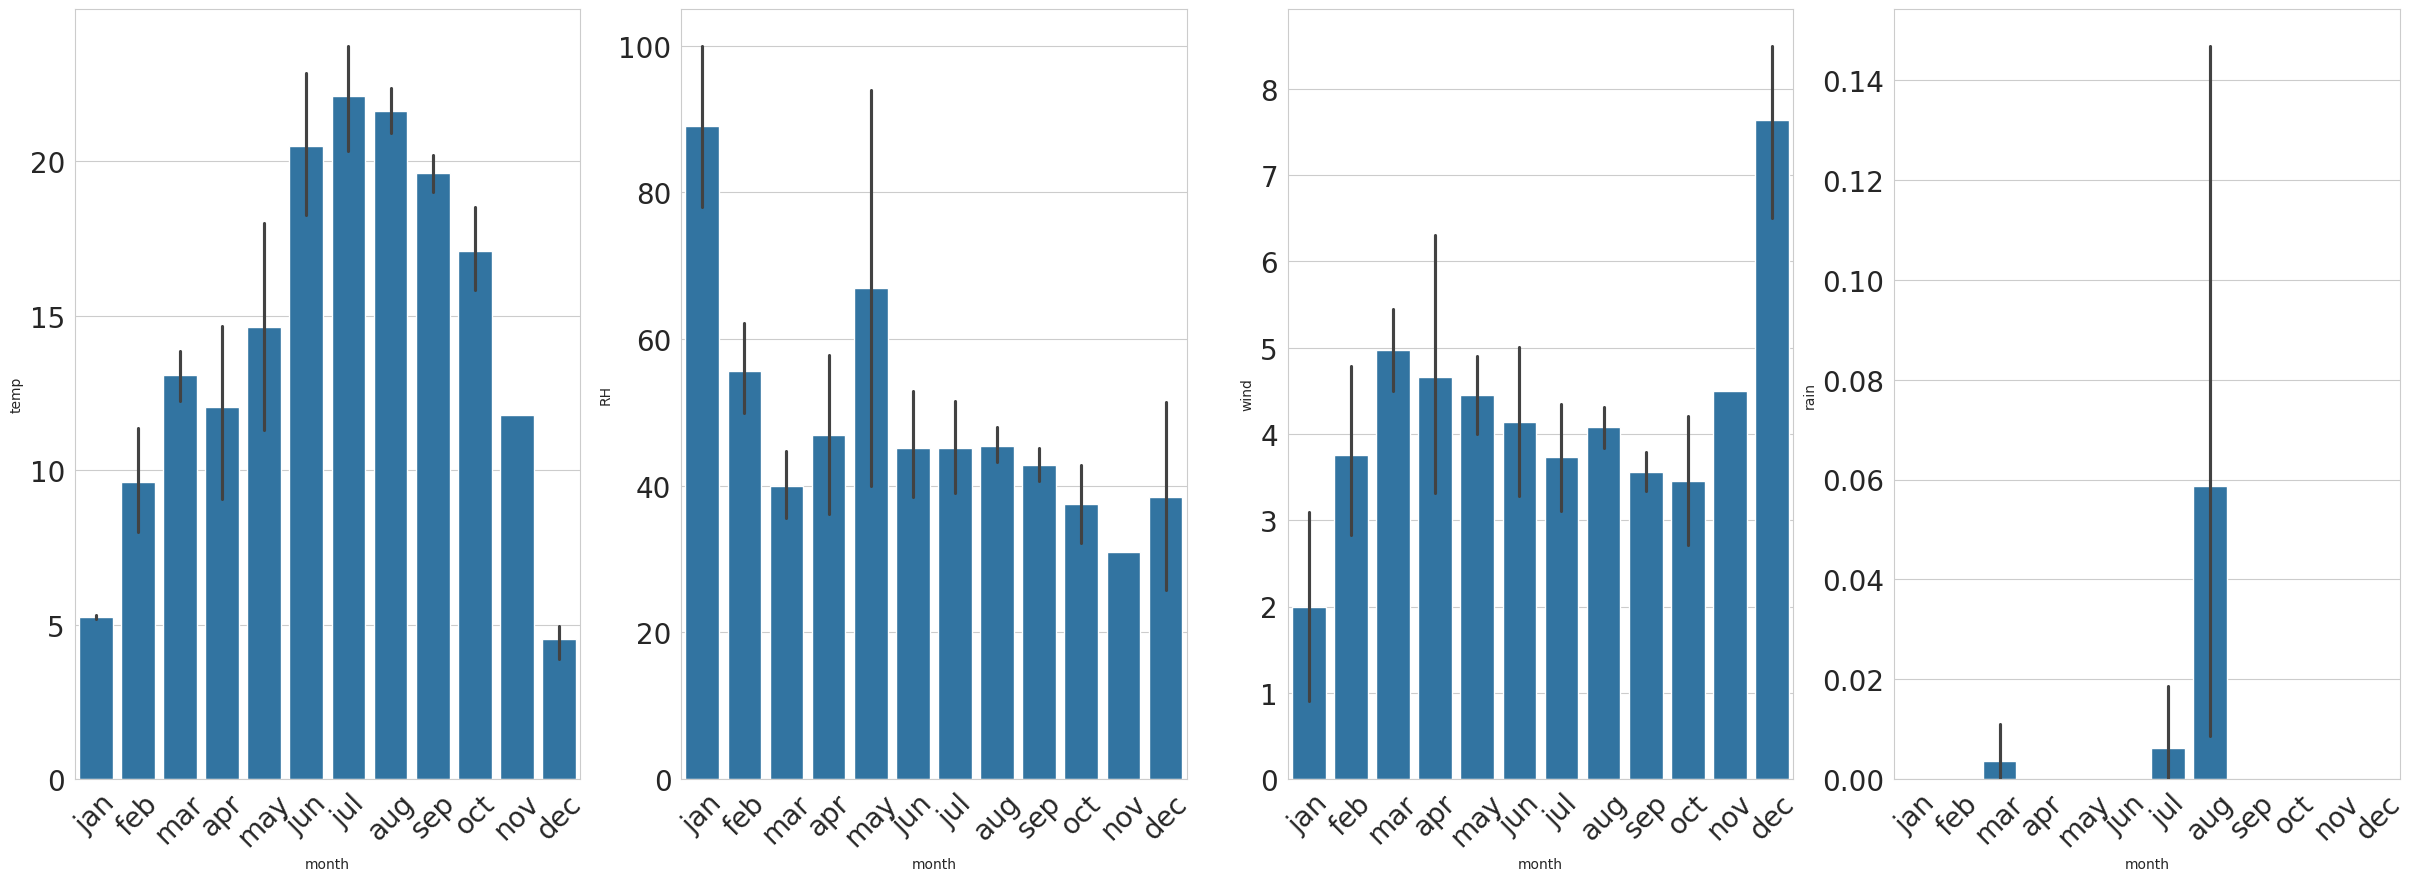

In [9]:
# This is the corrected code block
f, axs = plt.subplots(1, 4, figsize=(30, 10))
for ax, title, yval in zip(axs, titles, yvals):
    # This is the corrected line
    sns.barplot(x='month', y=yval, data=df, ax=ax)
    ax.tick_params(axis='x', rotation=45, labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

These figures above describe sequential trends of the four low-level features. As expected, temp is high in summer and low in winter. One thing to notice is that it only rains in August.

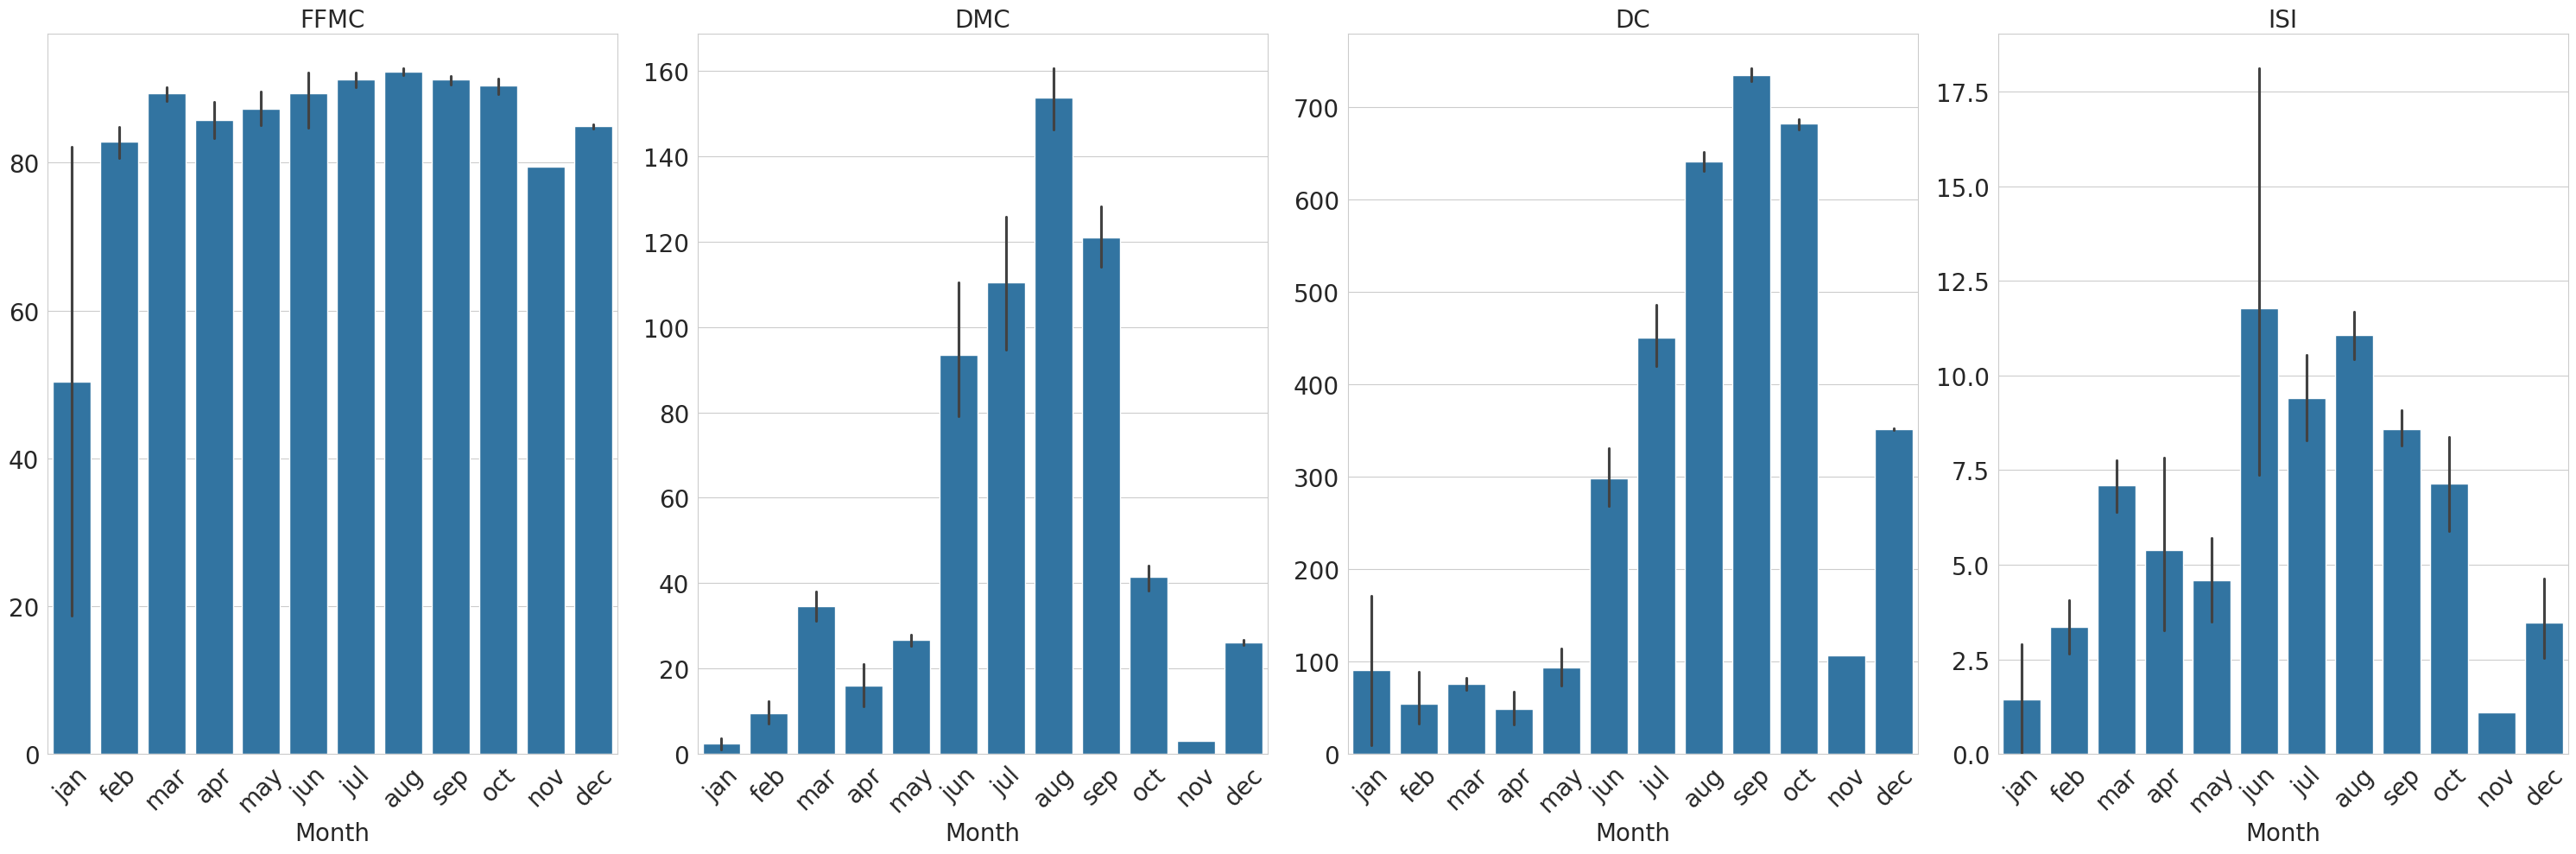

In [11]:
titles = ['FFMC', 'DMC', 'DC', 'ISI']
yvals = ['FFMC', 'DMC', 'DC', 'ISI']
f, axs = plt.subplots(1, 4, figsize=(30, 10))

for ax, title, yval in zip(axs, titles, yvals):
    # This is the corrected line
    sns.barplot(x='month', y=yval, data=df, ax=ax)

    ax.tick_params(axis='x', rotation=45, labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.set_xlabel('Month', fontsize=fontsize)
    ax.set_ylabel('')
    ax.set_title(title, fontsize=fontsize)

plt.tight_layout() # This helps to arrange the plots neatly
plt.show()

 **Analysis Summary: A Complex Relationship**

* **Peak Fire Risk:** The fire weather indices (`DMC`, `DC`, `ISI`) clearly indicate that **summer is the highest-risk season** for intense and fast-spreading fires.

* **High Variance in Damage:** However, the actual burned **`area`** is highly erratic and shows **no simple seasonal trend**.

* **Conclusion:** This contrast highlights the complexity of the problem. While conditions are riskiest in the summer, the actual outcome is unpredictable from a simple visual analysis, reinforcing the need for a machine learning model to capture the more subtle patterns.

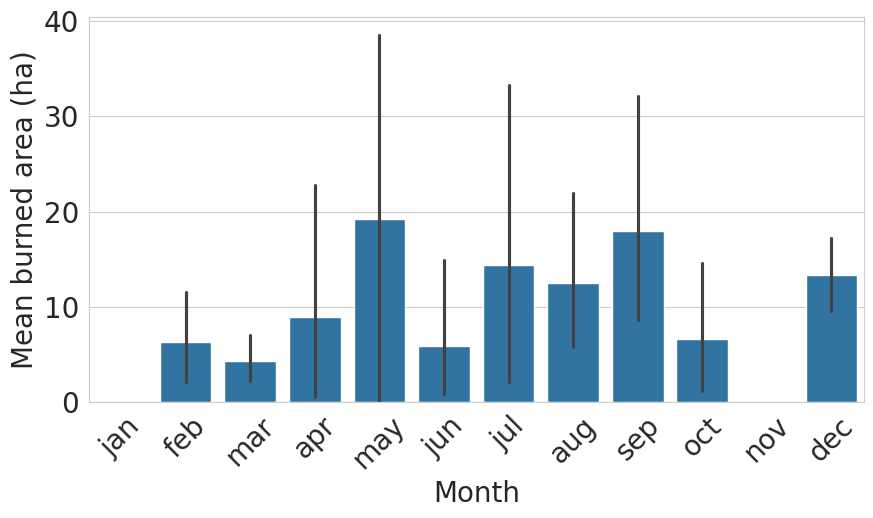

In [13]:
f, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='month', y='area', data=df, ax=ax)
ax.tick_params(axis='x', rotation=45, labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.set_xlabel('Month',fontsize=fontsize)
ax.set_ylabel('Mean burned area (ha)',fontsize=fontsize)
plt.show()

By locations

In [15]:
location_matrix = pd.DataFrame(0, index=np.arange(1,10), columns=np.arange(2,10)) #Y is horizontal for now
location_temp_matrix = location_matrix.copy()
location_RH_matrix = location_matrix.copy()
location_wind_matrix = location_matrix.copy()
location_rain_matrix = location_matrix.copy()

avg_by_location_df = (df.groupby(['X','Y']).mean(numeric_only=True))
for X,Y in zip(avg_by_location_df.index.get_level_values(0),avg_by_location_df.index.get_level_values(1)):
    location_temp_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'temp'])
    location_RH_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'RH'])
    location_wind_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'wind'])
    location_rain_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'rain'])

location_temp_matrix = location_temp_matrix.T
location_RH_matrix = location_RH_matrix.T
location_wind_matrix = location_wind_matrix.T
location_rain_matrix = location_rain_matrix.T

/tmp/ipython-input-1538578068.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.74736842105263' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  location_temp_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'temp'])
/tmp/ipython-input-1538578068.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '42.421052631578945' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  location_RH_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'RH'])
/tmp/ipython-input-1538578068.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.836842105263158' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  location_wind_matrix.loc[X,Y] = (avg_by_

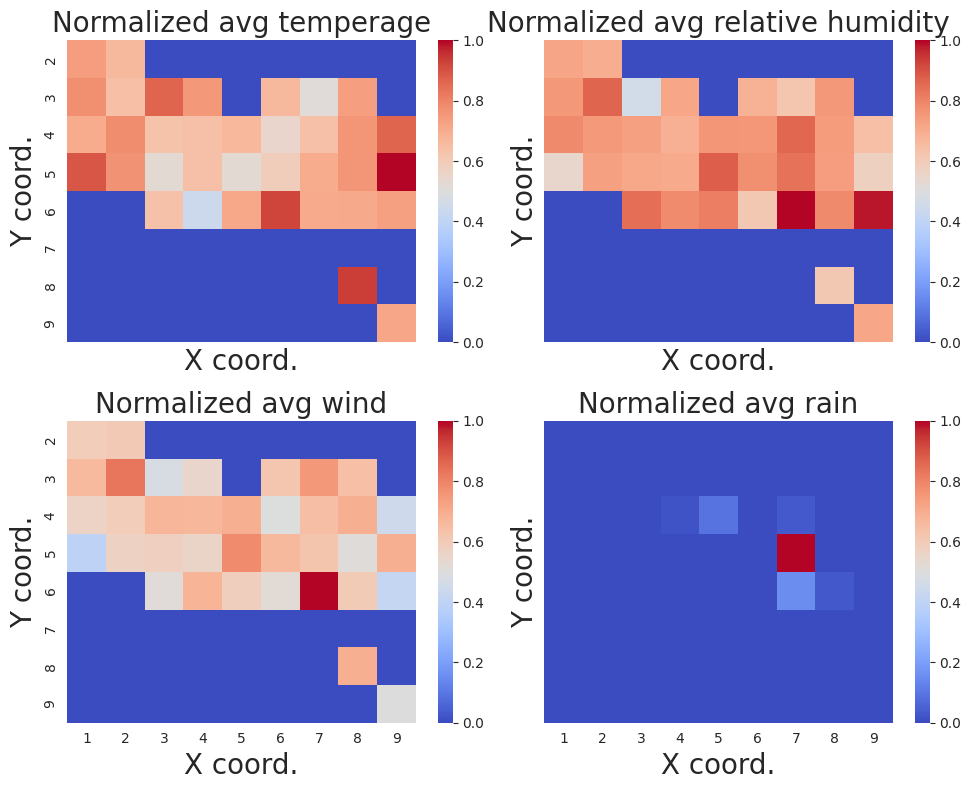

In [16]:
titles = ['Normalized avg temperage','Normalized avg relative humidity','Normalized avg wind','Normalized avg rain']
matvals = [location_temp_matrix/location_temp_matrix.max().max(),
           location_RH_matrix/location_RH_matrix.max().max(),
           location_wind_matrix/location_wind_matrix.max().max(),
           (location_rain_matrix/location_rain_matrix.max().max()).fillna(0)]
f, axs = plt.subplots(2,2,sharex=True, sharey=True,figsize=(10,8))
for ax,title,matval in zip(axs.reshape(-1),titles,matvals):
    sns.heatmap(matval, cmap = 'coolwarm',ax = ax)
    ax.set_xlabel('X coord.', fontsize=fontsize)
    ax.set_ylabel('Y coord.', fontsize=fontsize)
    ax.set_title(title,fontsize=fontsize)
plt.tight_layout()
plt.show()

This possibly illustrates the shape of the forest in general. Or, the location where the data was not collected from (interpreted as 0 in these figures) may have negligible chance of fire. It can be seen that `rain` is highly focused to the specific area of the forest. Illustrating this information in terms of `month` would be nicer, but that is not necessary for the purpose of this project.


This figure represents the average burned area in different locations. It is difficult to make clear assumptions what caused the large burned `area` at [8X8] coordinate.

/tmp/ipython-input-1193959829.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '11.57578947368421' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  location_area_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'area'])
/tmp/ipython-input-1193959829.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.714000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  location_area_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'area'])
/tmp/ipython-input-1193959829.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.018666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  location_area_matrix.loc[X,Y] = (avg_

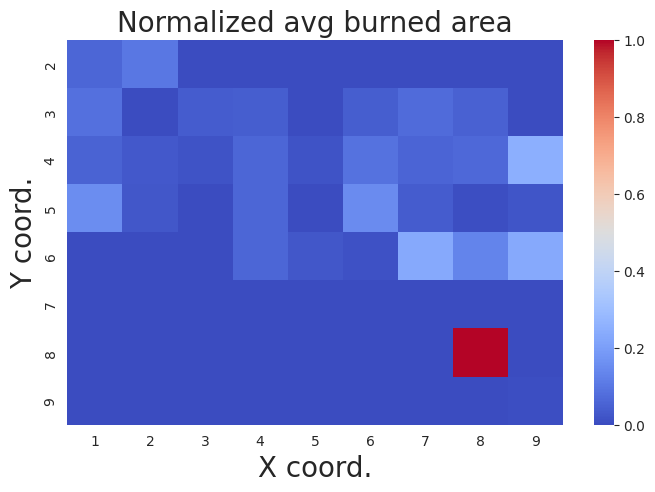

In [17]:
location_area_matrix = location_matrix.copy()

for X,Y in zip(avg_by_location_df.index.get_level_values(0),avg_by_location_df.index.get_level_values(1)):
    location_area_matrix.loc[X,Y] = (avg_by_location_df.loc[(X,Y),'area'])
location_area_matrix = location_area_matrix.T
location_area_matrix = location_area_matrix/location_area_matrix.max().max()
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(location_area_matrix,cmap='coolwarm',ax=ax)
ax.set_xlabel('X coord.', fontsize=fontsize)
ax.set_ylabel('Y coord.', fontsize=fontsize)
ax.set_title('Normalized avg burned area',fontsize=fontsize)
plt.show()

# **Feature engineering**

**Feature Engineering: Preparing Data for the Model**

Although our dataset is well-structured, a crucial step known as **Feature Engineering** is required to prepare it for the machine learning algorithm.

Our initial Exploratory Data Analysis (EDA) suggested that the spatial features (`X`, `Y`) and the temporal feature (`month`) may contain significant predictive power for the burned `area`. To statistically leverage this potential, we must first convert these features from their current format.

The correct approach is to treat them as **nominal categorical data**. We will therefore apply the **one-hot encoding** technique, which will transform them into an appropriate numerical format that the model can effectively utilize for training.

In [18]:
X_ohi = pd.get_dummies(df.X,prefix='X')
Y_ohi = pd.get_dummies(df.Y,prefix='Y')
Y_ohi.insert(5,'Y_7',0)
month_ohi = pd.get_dummies(df.month)
df = df.drop(['X','Y','month','day'],axis=1)
df = pd.concat([df,X_ohi,Y_ohi,month_ohi],axis=1)

In [19]:
print(df.columns)
print('New data has {} entries and {} features.'.format(df.shape[0],df.shape[1]))

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area', 'X_1',
       'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'Y_2', 'Y_3',
       'Y_4', 'Y_5', 'Y_6', 'Y_7', 'Y_8', 'Y_9', 'jan', 'feb', 'mar', 'apr',
       'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
      dtype='object')
New data has 517 entries and 38 features.


New data has 517 entries and 38 features.
In the new dataframe,` X,Y `and `month` are one-hot-encoded and `day` feature has been dropped. Now the data has 38 features in total.

# **Initial ML fitting**

The entire dataset only has 517 entires. Therefore, only 10% of it (~50) will be allocated as test set and others will be utlized to fit the model. The model will be selected via 5-fold CV evaluation.

Appropriate evaluation metrics for general regression problems include MAE and RMSE. There are similiar in nature, but RMSE is more sensitive to higher errors as the errors are squared before being averaged. Therefore, this project will use RMSE as a main metric.

**Spliting into X and y sets**


Test set is completely isolated from the training process.

In [20]:
from sklearn.model_selection import train_test_split
X = df.drop('area',axis=1)
y = df.area

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=50)

Dummy regressor

In [22]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

dummy_constant = DummyRegressor(strategy='constant',constant=0).fit(X_train,y_train)
y_predicted_dummy = dummy_constant.predict(X_test)
print('RMSE of dummy regressor (test set) = {}'.format(round(mean_squared_error(y_test,y_predicted_dummy)**0.5, 3)))

RMSE of dummy regressor (test set) = 17.097


 **Establishing a Baseline and Defining Our Strategy**

An interesting initial finding is that a simple **Dummy Regressor**, which always predicts a burned area of zero, actually achieves a better RMSE score than the model from the original study. While this might seem counterintuitive, it highlights the core challenge of this project: **severe data imbalance**.

Based on RMSE, the dummy regressor seems to be outperforming the model published by Cortez and Morais. While the metrics do not represent the entire performance of the model, high performance dummy models are typical in the imbalanced dataset just because the ocurrance of the event is extremely rare. A good model is the one that can predict these rarly occuring events from the zero baseline.

---


**XGBooster Regressor and 5-fold CV**

XGB regressor is a powerful and flexible model that has many tuning parameters. For this project, XGB regressor will be mainly used for fitting, while more attention is given to featuer engineering/transformation/selection processes to optimize the performance of the XGB regressor. The optimal parameters of the model will be searched through 5-fold CV and the model performance will be reported based on the test set.

In [23]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV

grid_params = {'n_estimators':[3,10,30,100,300],'max_depth':[1,3,10,30],'learning_rate':[0.05,0.1,0.3,1]}
xgbr_grid_RMSE = GridSearchCV(XGBRegressor(),grid_params,cv=5,scoring='neg_mean_squared_error').fit(X_train,y_train)
print(xgbr_grid_RMSE.best_params_)
print('RMSE of xgbr (5-fold CV) = {:.3f}'.format(((-1*(xgbr_grid_RMSE.best_score_))**0.5)))

{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 3}
RMSE of xgbr (5-fold CV) = 66.968


XGB regressor evalution on test set

In [26]:
xgbr_RMSE = XGBRegressor(learning_rate =0.3, max_depth=1, n_estimators=3).fit(X_train,y_train)
y_predicted_xgbr_RMSE = xgbr_RMSE.predict(X_test)
print('RMSE of xgbr (test set) = {}'.format(round(mean_squared_error(y_test,y_predicted_xgbr_RMSE)**0.5, 3)))

RMSE of xgbr (test set) = 16.188


The RMSE of XGBR from 5-fold CV is quite similar to the one published by Cortez and Morais. When this model is evaluated on the test set, its RMSE is not really better than that of the dummy regressor. Also, the difference in CV score and test score is really large, indicating that the score is heavily affected by the difference of target variable distribution in train/test sets. This can be confirmed by comparing their skewness.

In [27]:
print('skewness of y_train is {:.3f}'.format(st.skew(y_train)))
print('skewness of y_test is {:.3f}'.format(st.skew(y_test)))

skewness of y_train is 12.244
skewness of y_test is 3.582


# **Feature transformation**

 **Addressing Data Skewness with Feature Transformation**

Our exploratory analysis revealed that several numeric features are not normally distributed, a statistical property known as **skewness**. This is particularly problematic for the target variable.

* **The Target Variable (`area`):** The most critical issue is the severe skewness in the burned `area` data. This heavy imbalance can significantly hinder a model's ability to learn effectively. To mitigate this, we will apply a common and powerful technique: the **Log Transformation**. This method helps to normalize the distribution and stabilize the model's performance.

* **Other Skewed Features (`FFMC`, `rain`):** While other features like `FFMC` and `rain` also exhibit skewness, our initial EDA suggested they have limited predictive power or low variance. Therefore, to avoid unnecessary complexity and focus on what matters most, we will concentrate our transformation efforts solely on the `area` variable, which is expected to yield the most significant improvement.

In [28]:
y_train = np.log(y_train+1)

In [29]:
print('skewness of y_train after log transformation is {:.3f}.'.format(st.skew(y_train)))

skewness of y_train after log transformation is 1.239.


After fitting, the predicted `area `can be inversely transformed by np.expm1() for evaluation on the test set.

# **ML fitting with feature transformation**

XGB regressor and 5-fold CV with feature transformation

In [30]:
grid_params = {'n_estimators':[3,10,30,100,300],'max_depth':[1,3,10,30],'learning_rate':[0.05,0.1,0.3,1]}
xgbr_grid_RMSE = GridSearchCV(XGBRegressor(),grid_params,cv=5,scoring='neg_mean_squared_error').fit(X_train,y_train)
print(xgbr_grid_RMSE.best_params_)
print('RMSE of xgbr (5-fold CV) = {:.3f}'.format(((-1*(xgbr_grid_RMSE.best_score_))**0.5)))

{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 30}
RMSE of xgbr (5-fold CV) = 1.410


After feature transformation, their optimizing parameters have changed and

the 5-fold CV RMSE score has improved from 67.244 to 1.410.

**XGB regressor evalution on test set with feature transformation**

In [32]:
xgbr_RMSE = XGBRegressor(learning_rate =0.3, max_depth=1, n_estimators=10).fit(X_train,y_train)
y_predicted_xgbr_RMSE = xgbr_RMSE.predict(X_test)
y_predicted_xgbr_RMSE = np.expm1(y_predicted_xgbr_RMSE) #inverse transformation
print('RMSE of xgbr (test set) = {}'.format(round(mean_squared_error(y_test,y_predicted_xgbr_RMSE)**0.5, 3)))

RMSE of xgbr (test set) = 16.295


The RMSE of CV set showed remarkable improvement, but unfortunately, the RMSE of xgbr on test set got slightly worse than before even after the transformation.

Learning curve

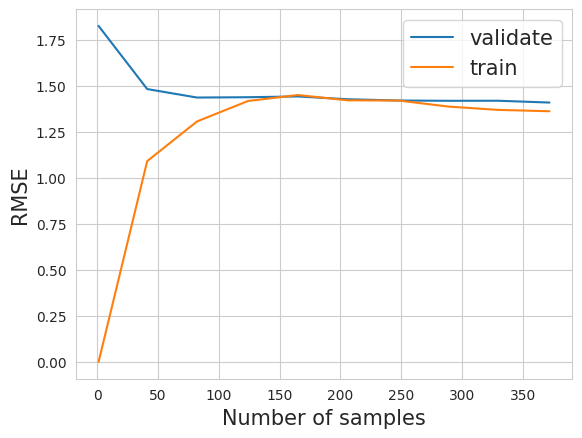

In [34]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(XGBRegressor(learning_rate =0.3, max_depth=1, n_estimators=10), X_train, y_train, cv=5, train_sizes =np.linspace(0.0001, 1.0, 10),scoring='neg_mean_squared_error')
plt.figure()
plt.plot(train_sizes,np.mean((valid_scores*-1)**0.5,axis=1),label='validate')
plt.plot(train_sizes,np.mean((train_scores*-1)**0.5,axis=1),label='train')
plt.xlabel('Number of samples',fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.legend(fontsize=15)

The learning curve of CV looks okay as expected. This may indicate that the model is not overfitting, but the problem is still the distribution difference of the target variable between train and test sets.

Therefore, this may not be entirely necessary, but some features may be removed to ahiceve a simpler model. This dataset is composed of many features that are related to each ohter. For example, index values are calculated from the low-level features. The redundancies can be removed by selecting a few features with the most predictive powers.

# **ML fitting with feature transformation and selection**

Feature selection

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

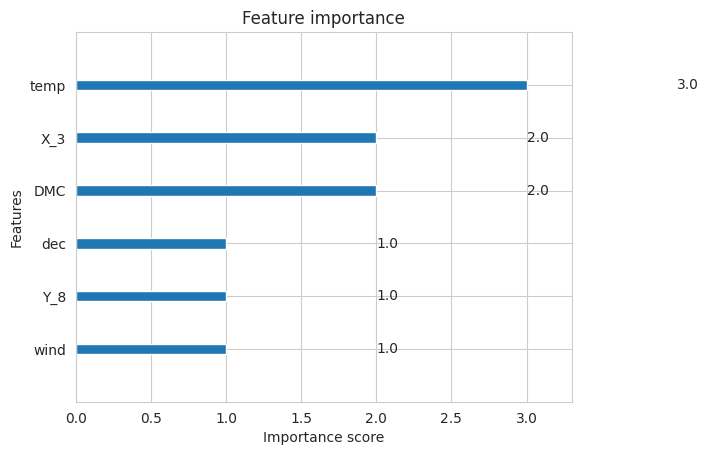

In [35]:
plot_importance(xgbr_RMSE,max_num_features=10)

Based on feature importance measure by XGB Regressor model, the six features are important while all others have no predictive power.

**XGB regressor and 5-fold CV evalution with feature transformation and selection**

In [36]:
X_train = X_train[['temp', 'X_3', 'DMC', 'wind','Y_8','dec']]
grid_params = {'n_estimators':[3,10,30,100,300],'max_depth':[1,3,10,30],'learning_rate':[0.05,0.1,0.3,1]}
xgbr_grid_RMSE = GridSearchCV(XGBRegressor(),grid_params,cv=5,scoring='neg_mean_squared_error').fit(X_train,y_train)
print(xgbr_grid_RMSE.best_params_)
print('RMSE of xgbr (5-fold CV) = {:.3f}'.format(((-1*(xgbr_grid_RMSE.best_score_))**0.5)))

{'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 10}
RMSE of xgbr (5-fold CV) = 1.404


**XGB regressor evalution on test set with feature transformation and selection**

In [38]:
X_test = X_test[['temp', 'X_3', 'DMC', 'wind','Y_8','dec']]
xgbr_RMSE = XGBRegressor(learning_rate =0.3, max_depth=1, n_estimators=10).fit(X_train,y_train)
y_predicted_xgbr_RMSE = xgbr_RMSE.predict(X_test)
y_predicted_xgbr_RMSE = np.expm1(y_predicted_xgbr_RMSE)

print('RMSE of xgbr (test set) = {}'.format(round(mean_squared_error(y_test,y_predicted_xgbr_RMSE)**0.5, 3)))

RMSE of xgbr (test set) = 16.295


 **Diagnosing the Model's Performance: The Challenge of Imbalance**

Despite our initial modeling efforts, the performance remains unsatisfactory, showing only a marginal improvement over the baseline dummy regressor. The stability of the RMSE score indicates this is not an overfitting issue, but a more fundamental problem.

A closer look at the predictions reveals a clear pattern: the model consistently predicts very low values for the burned `area`. This is a direct consequence of the severe data imbalance. Since the vast majority of data points have a burned `area` close to zero, the model achieves a deceptively reasonable RMSE by simply "playing it safe" and predicting small numbers. This is not an acceptable outcome, as the model fails at its primary goal: **predicting significant fires**.

---

 **Next Step: Addressing the Root Cause with Oversampling**

The evidence strongly suggests that the model is still overwhelmed by the skewed target variable. To address this root cause directly, the next logical step is to implement an **oversampling** technique.

The goal of oversampling is to artificially increase the representation of the rare, high-impact events (large fires) in our training data. By showing the model more examples of what a significant fire looks like, we can force it to learn their underlying patterns and become more effective at predicting them.

In [39]:
ser = pd.Series(y_predicted_xgbr_RMSE,index=y_test.index,name='predicted_area')
pd.concat([y_test,ser],axis=1).head(20)

,area,predicted_area
463,5.39,2.681963
418,2.44,2.999629
391,30.18,1.595053
370,11.06,2.460097
166,2.29,1.595053
453,0.00,2.460097
384,12.18,2.460097
115,0.00,1.133387
23,0.00,1.804351
408,7.80,2.460097


# **Oversampling**

Arbitrarily adding duplicates of samples (with burned area > 10, >50 and >100) to the training set
While the test set is totally isolated for the later evaluation, duplicates of the samples that have medium/large burned area can be added to the training set for oversampling.

In [41]:
df_oversampling = df[['temp', 'X_3', 'DMC', 'wind','Y_8','dec','area']]

train,test = train_test_split(df_oversampling,test_size=0.05,random_state = 300)
copy_10 = train[train.area>10]
copy_50 = train[train.area>50]
copy_100 = train[train.area>100]
bulk = pd.concat([copy_10,copy_50,copy_50,copy_50,copy_100,copy_100])
train = pd.concat([train,bulk]).sample(frac=1).reset_index(drop=True)

X_train = train.drop('area',axis=1)
y_train = train.area
y_train = np.log(y_train+1)

X_test = test.drop('area',axis=1)
y_test = test.area

In [43]:
grid_params = {'n_estimators':[3,10,30,100,300],'max_depth':[1,3,10,30],'learning_rate':[0.05,0.1,0.3,1]}
xgbr_grid_RMSE = GridSearchCV(XGBRegressor(),grid_params,cv=5,scoring='neg_mean_squared_error').fit(X_train,y_train)
print(xgbr_grid_RMSE.best_params_)
print('RMSE of xgbr (5-fold CV) = {:.3f}'.format(((-1*(xgbr_grid_RMSE.best_score_))**0.5)))

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
RMSE of xgbr (5-fold CV) = 1.240


**XGB regressor evalution on test set with feature transformation, selection and oversampling**

In [45]:
xgbr_RMSE = XGBRegressor(learning_rate=0.3, max_depth=10, n_estimators=10).fit(X_train,y_train)
y_predicted_xgbr_RMSE = xgbr_RMSE.predict(X_test)
y_predicted_xgbr_RMSE = np.expm1(y_predicted_xgbr_RMSE)
print('RMSE of xgbr (test set) = {}'.format(round(mean_squared_error(y_test,y_predicted_xgbr_RMSE)**0.5, 3)))

RMSE of xgbr (test set) = 3.765


**Final Model Summary**

* **Massive Performance Gain:** The combination of oversampling and log transformation was highly effective. The final **RMSE on the test set dropped to 3.765**, a significant improvement over all previous attempts.

* **Behavioral Change:** The model's core behavior has fundamentally changed. It no longer defaults to predicting zero and is now capable of **predicting significant, non-zero fire areas**.

* **Desirable Tendency:** The model shows a slight tendency to overestimate burned areas. This is a positive trait for a risk-assessment model, as it prioritizes caution. In conclusion, the final model is both statistically strong and practically useful.

In [46]:
ser = pd.Series(y_predicted_xgbr_RMSE,index=y_test.index,name='predicted_area')
pd.concat([y_test,ser],axis=1).head(20)

,area,predicted_area
162,1.94,2.224104
18,0.00,0.535158
182,6.38,0.328880
143,0.71,2.365234
29,0.00,7.158200
254,10.34,4.820501
34,0.00,4.665899
477,7.36,0.216787
275,5.38,3.014334
114,0.00,0.127761


# *Conclusion*

**Conclusion and Final Thoughts**


This project has demonstrated that predicting forest fire damage is a challenging regression task. The primary difficulty stemmed from the dataset's inherent characteristics: a target variable `(area)` that was severely imbalanced towards zero and features with relatively low individual predictive power.

Several approaches were implemented, including feature transformation and selection. While these methods successfully improved the error metrics `(MAE and RMSE)`, the model's practical ability to predict significant fire events remained limited.

The most impactful technique proved to be oversampling. By intentionally increasing the presence of under-represented data points` (large fires)` in the training set, we observed a dramatic and immediate improvement in the model's performance. This confirmed that addressing the data imbalance was the key to unlocking the model's potential.



---




**Future Work**

For further optimization, the following steps could be considered:


*   Exploring alternative data balancing techniques like undersampling.

*  Experimenting with different regression algorithms that may be better suited to this type of complex, imbalanced problem.


